In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from sklearn import preprocessing
from sklearn.cluster import HDBSCAN as hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, fowlkes_mallows_score, normalized_mutual_info_score  
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
import random
import glob
import os


import warnings
warnings.filterwarnings('ignore')

In [2]:
customers = pd.read_csv("./archive-4/segmentation data.csv")
customers.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [3]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [4]:
customers.drop(columns='ID', inplace=True)

In [5]:
customers.shape

(2000, 7)

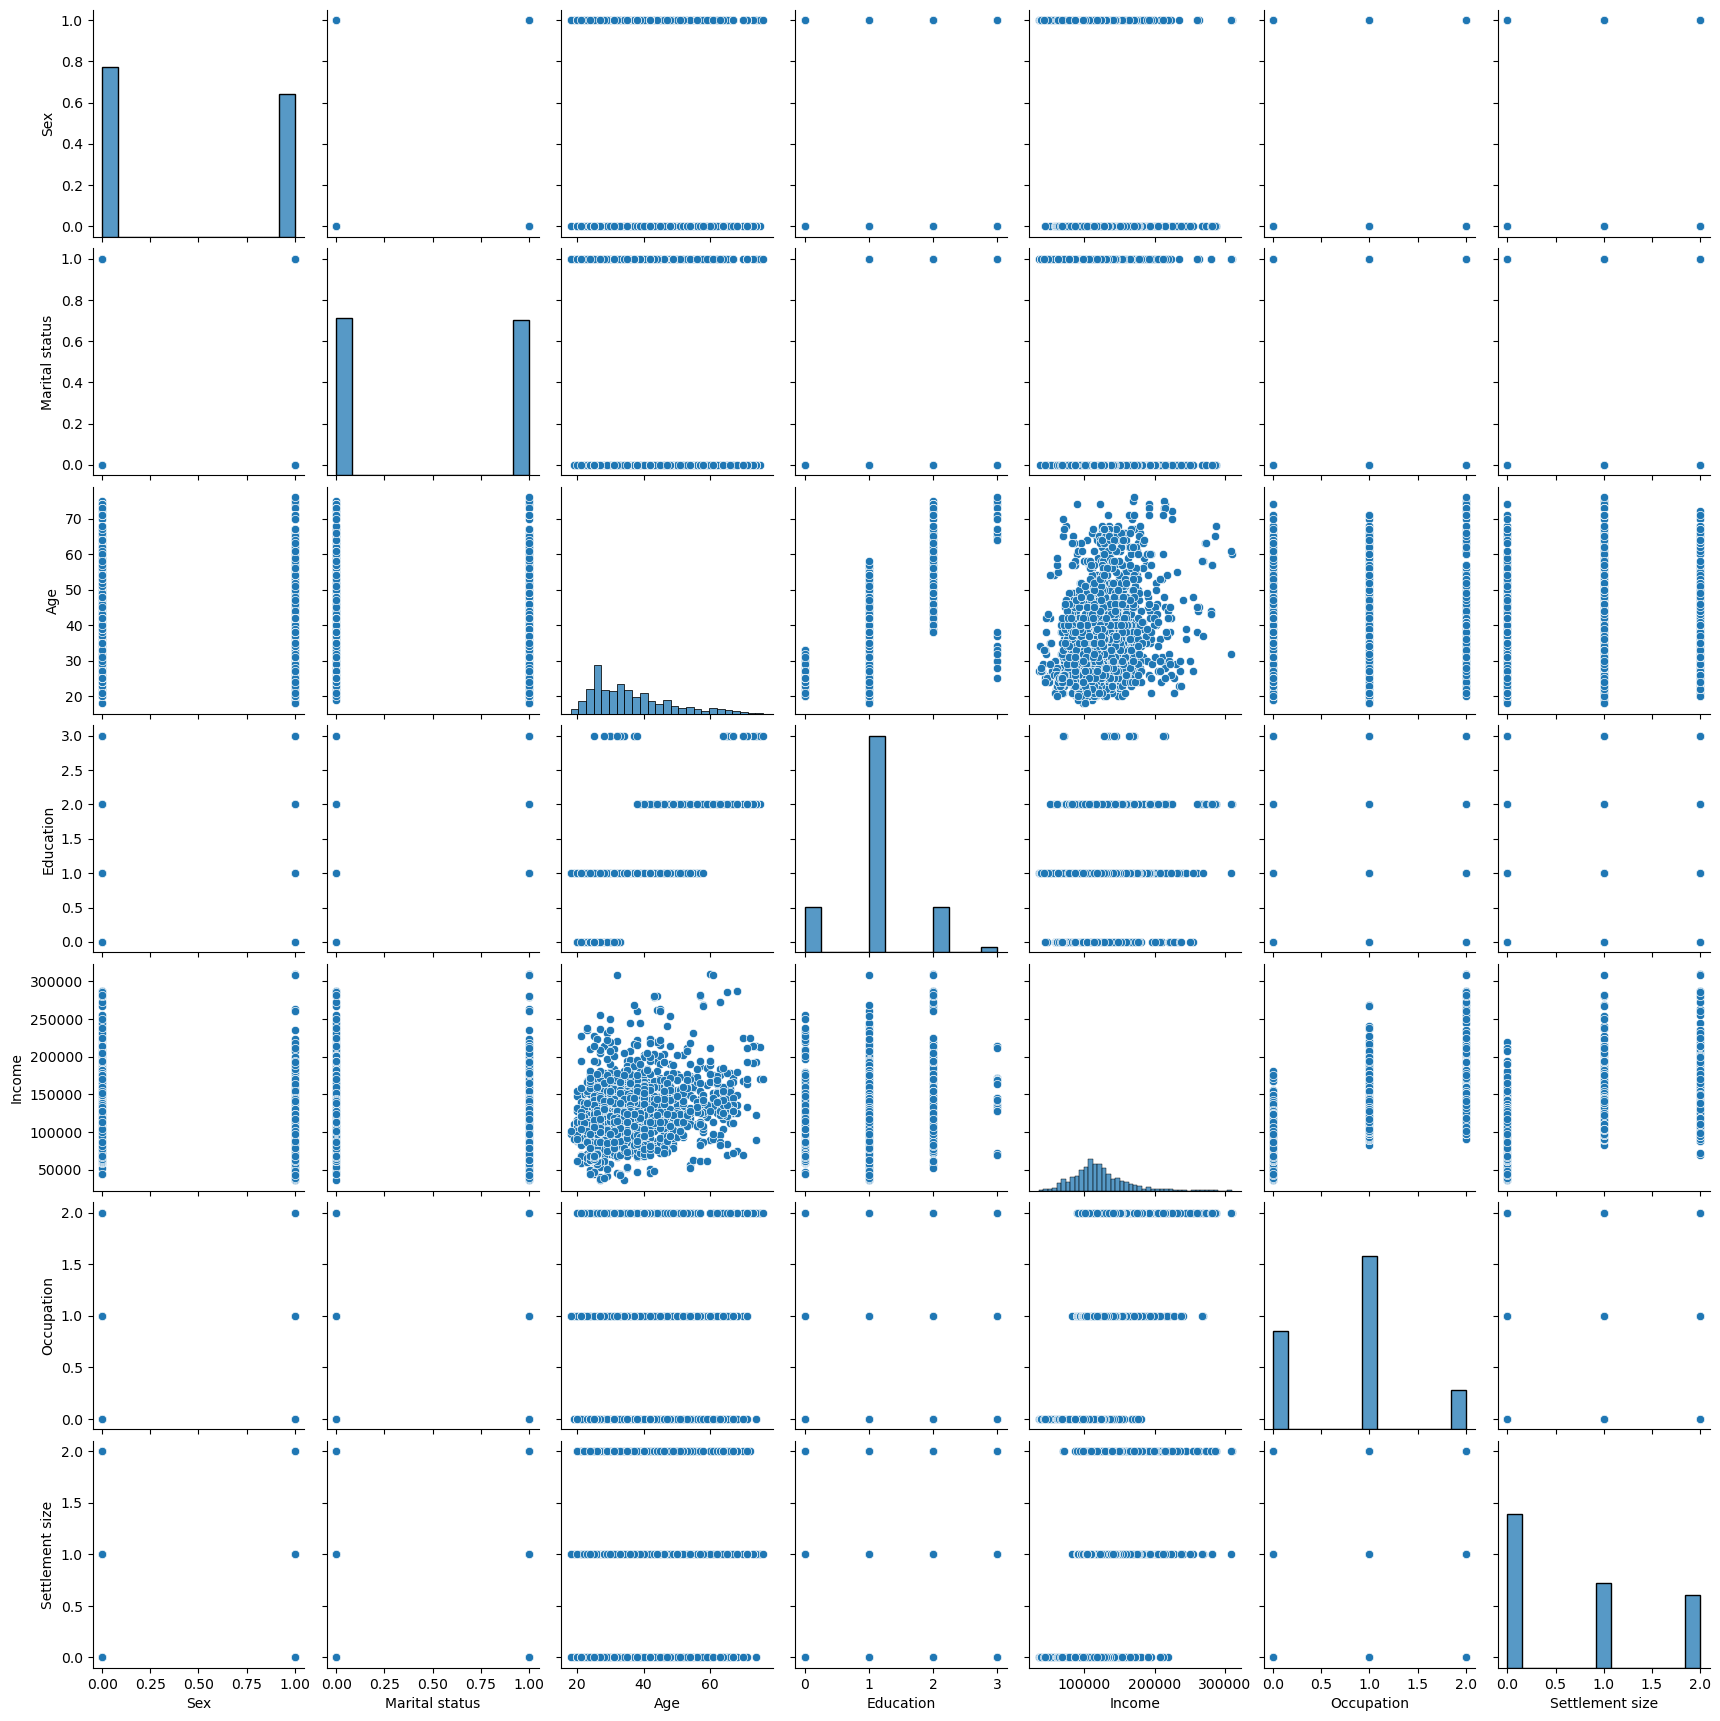

In [6]:
sns.pairplot(customers)
plt.show()

In [7]:
columns = customers.columns
customers = StandardScaler().fit_transform(customers)
customers = pd.DataFrame(customers, columns=columns)

In [8]:
def dunn_index(data, labels):
    unique_clusters = np.unique(labels)
    num_clusters = len(unique_clusters)
    
    if num_clusters < 2:  # Dunn Index needs at least two clusters
        return -1
    
    # Intra-cluster distances (max distance within each cluster)
    intra_cluster_distances = []
    for cluster in unique_clusters:
        points_in_cluster = data[labels == cluster]
        if len(points_in_cluster) > 1:
            intra_cluster_distances.append(np.max(cdist(points_in_cluster, points_in_cluster)))
        else:
            intra_cluster_distances.append(0)  # Single-point clusters have 0 intra-cluster distance
    
    # Inter-cluster distances (min distance between clusters)
    inter_cluster_distances = []
    for i, cluster_i in enumerate(unique_clusters):
        points_i = data[labels == cluster_i]
        for j, cluster_j in enumerate(unique_clusters):
            if j > i:
                points_j = data[labels == cluster_j]
                inter_cluster_distances.append(np.min(cdist(points_i, points_j)))
    
    # Dunn Index: ratio of minimum inter-cluster distance to maximum intra-cluster distance
    dunn = np.min(inter_cluster_distances) / np.max(intra_cluster_distances)
    
    return dunn


Min Cluster size 10 number of clusters: 37
Min Cluster size 20 number of clusters: 26
Min Cluster size 30 number of clusters: 19
Min Cluster size 40 number of clusters: 15
Min Cluster size 50 number of clusters: 11
Min Cluster size 60 number of clusters: 10
Min Cluster size 70 number of clusters: 9
Min Cluster size 80 number of clusters: 7
Min Cluster size 90 number of clusters: 6
Min Cluster size 100 number of clusters: 5
Min Cluster size 110 number of clusters: 4
Min Cluster size 120 number of clusters: 4
Min Cluster size 130 number of clusters: 4
Min Cluster size 140 number of clusters: 3


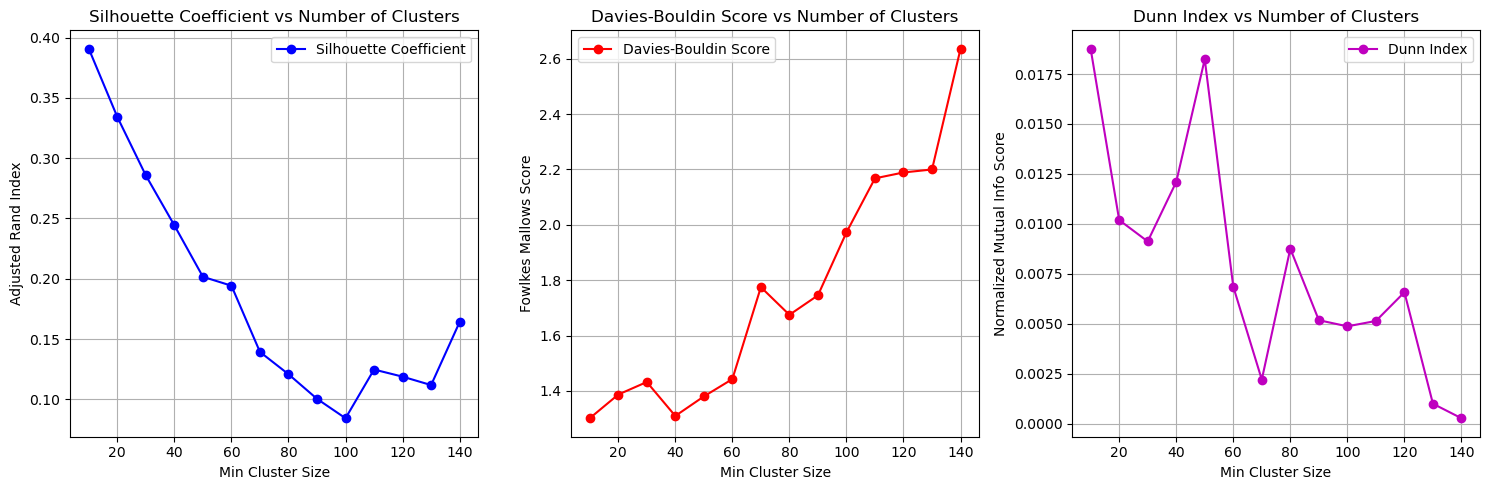

In [9]:
list_k = list(range(10, 150, 10))
silhouette = []
d_b = []
dunn_scores = []

for i in list_k:
    hdbscan_model = hdbscan(min_cluster_size=i)
    hdbscan_model.fit(customers)
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))

    s_score = silhouette_score(customers, hdbscan_labels)
    db_score = davies_bouldin_score(customers, hdbscan_labels)
    dunn_score = dunn_index(customers, hdbscan_labels)

    silhouette.append(s_score)
    d_b.append(db_score)
    dunn_scores.append(dunn_score)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(list_k, silhouette, marker='o', linestyle='-', color='b', label="Silhouette Coefficient")
ax[0].set_title('Silhouette Coefficient vs Number of Clusters')
ax[0].set_xlabel('Min Cluster Size')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(list_k, d_b, marker='o', linestyle='-', color='r', label="Davies-Bouldin Score")
ax[1].set_title('Davies-Bouldin Score vs Number of Clusters')
ax[1].set_xlabel('Min Cluster Size')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(list_k, dunn_scores, marker='o', linestyle='-', color='m', label="Dunn Index")
ax[2].set_title('Dunn Index vs Number of Clusters')
ax[2].set_xlabel('Min Cluster Size')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


Min Cluster size 0.1 number of clusters: 59
Min Cluster size 0.2 number of clusters: 59
Min Cluster size 0.3 number of clusters: 58
Min Cluster size 0.5 number of clusters: 55
Min Cluster size 0.7 number of clusters: 53
Min Cluster size 1.0 number of clusters: 51


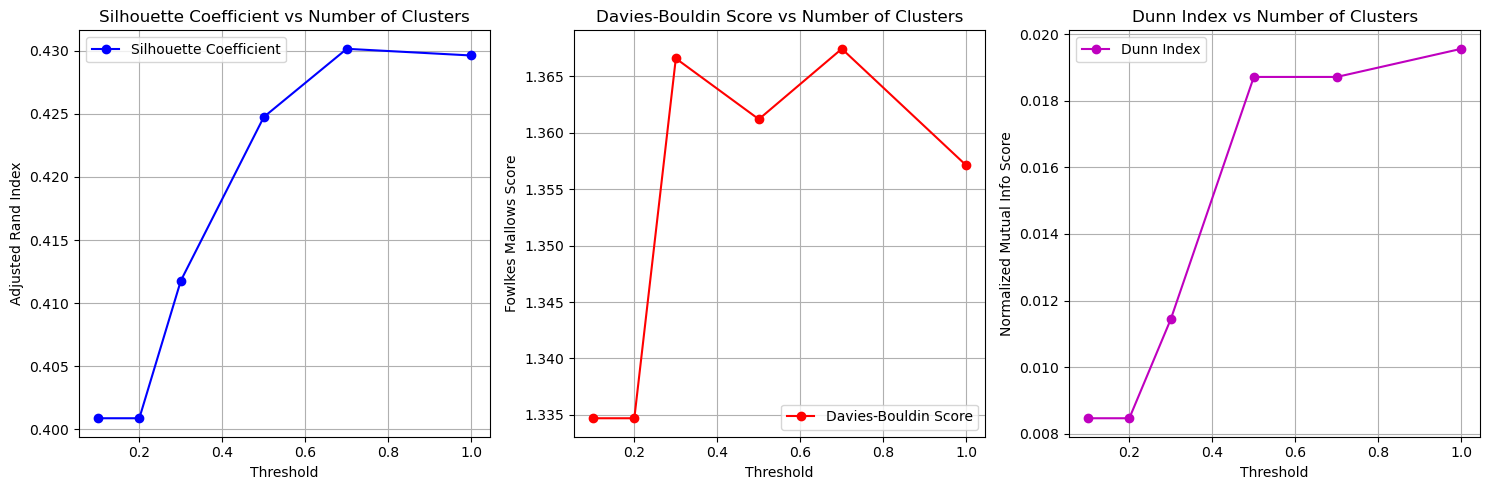

In [10]:
thresholds = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
silhouette = []
d_b = []
dunn_scores = []

for i in thresholds:
    hdbscan_model = hdbscan(cluster_selection_epsilon=i)
    hdbscan_model.fit(customers)
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))

    s_score = silhouette_score(customers, hdbscan_labels)
    db_score = davies_bouldin_score(customers, hdbscan_labels)
    dunn_score = dunn_index(customers, hdbscan_labels)

    silhouette.append(s_score)
    d_b.append(db_score)
    dunn_scores.append(dunn_score)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(thresholds, silhouette, marker='o', linestyle='-', color='b', label="Silhouette Coefficient")
ax[0].set_title('Silhouette Coefficient vs Number of Clusters')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(thresholds, d_b, marker='o', linestyle='-', color='r', label="Davies-Bouldin Score")
ax[1].set_title('Davies-Bouldin Score vs Number of Clusters')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(thresholds, dunn_scores, marker='o', linestyle='-', color='m', label="Dunn Index")
ax[2].set_title('Dunn Index vs Number of Clusters')
ax[2].set_xlabel('Threshold')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


Min Cluster size 10 number of clusters: 59
Min Cluster size 20 number of clusters: 59
Min Cluster size 30 number of clusters: 59
Min Cluster size 40 number of clusters: 59
Min Cluster size 50 number of clusters: 59
Min Cluster size 60 number of clusters: 59
Min Cluster size 70 number of clusters: 59
Min Cluster size 80 number of clusters: 59
Min Cluster size 90 number of clusters: 59
Min Cluster size 100 number of clusters: 59


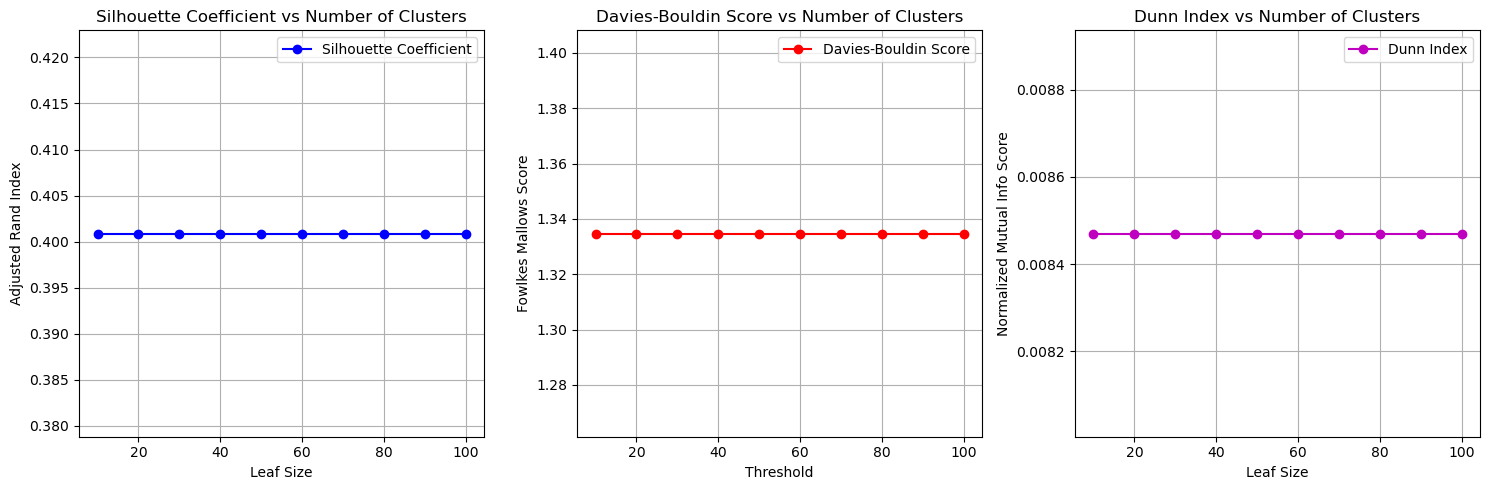

In [11]:
leaf_size = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
silhouette = []
d_b = []
dunn_scores = []

for i in leaf_size:
    hdbscan_model = hdbscan(leaf_size=i)
    hdbscan_model.fit(customers)
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))

    s_score = silhouette_score(customers, hdbscan_labels)
    db_score = davies_bouldin_score(customers, hdbscan_labels)
    dunn_score = dunn_index(customers, hdbscan_labels)

    silhouette.append(s_score)
    d_b.append(db_score)
    dunn_scores.append(dunn_score)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(leaf_size, silhouette, marker='o', linestyle='-', color='b', label="Silhouette Coefficient")
ax[0].set_title('Silhouette Coefficient vs Number of Clusters')
ax[0].set_xlabel('Leaf Size')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(leaf_size, d_b, marker='o', linestyle='-', color='r', label="Davies-Bouldin Score")
ax[1].set_title('Davies-Bouldin Score vs Number of Clusters')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(leaf_size, dunn_scores, marker='o', linestyle='-', color='m', label="Dunn Index")
ax[2].set_title('Dunn Index vs Number of Clusters')
ax[2].set_xlabel('Leaf Size')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


In [12]:
credit_score = pd.read_csv('./archive-3/train.csv')
credit_score.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [13]:
credit_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [14]:
credit_score.shape

(100000, 28)

In [15]:
credit_score['Occupation'].unique()

array(['Scientist', '_______', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

In [16]:
credit_score['Credit_Score'].unique()

array(['Good', 'Standard', 'Poor'], dtype=object)

In [17]:
credit_score['Occupation'] = credit_score['Occupation'].replace('_______', 'Unemployed')

In [18]:
one_hot_encoded_data = pd.get_dummies(credit_score, columns = ['Occupation', 'Payment_of_Min_Amount','Payment_Behaviour'])
bool_cols = one_hot_encoded_data.select_dtypes(include=[bool]).columns
one_hot_encoded_data[bool_cols] = one_hot_encoded_data[bool_cols].astype(int)

In [19]:
le = preprocessing.LabelEncoder()
one_hot_encoded_data['Credit_Score'] = le.fit_transform(one_hot_encoded_data['Credit_Score'])
one_hot_encoded_data['Credit_Score'].unique()

array([0, 2, 1])

In [20]:
credit_score_num = one_hot_encoded_data.copy()

credit_score_num = credit_score_num.select_dtypes(include=[np.number])

credit_score_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 35 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   Monthly_Inhand_Salary                               84998 non-null   float64
 1   Num_Bank_Accounts                                   100000 non-null  int64  
 2   Num_Credit_Card                                     100000 non-null  int64  
 3   Interest_Rate                                       100000 non-null  int64  
 4   Delay_from_due_date                                 100000 non-null  int64  
 5   Num_Credit_Inquiries                                98035 non-null   float64
 6   Credit_Utilization_Ratio                            100000 non-null  float64
 7   Total_EMI_per_month                                 100000 non-null  float64
 8   Credit_Score                                        100000 non-nu

In [21]:
credit_score_num.dropna(inplace=True)
credit_score_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83316 entries, 0 to 99999
Data columns (total 35 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Monthly_Inhand_Salary                               83316 non-null  float64
 1   Num_Bank_Accounts                                   83316 non-null  int64  
 2   Num_Credit_Card                                     83316 non-null  int64  
 3   Interest_Rate                                       83316 non-null  int64  
 4   Delay_from_due_date                                 83316 non-null  int64  
 5   Num_Credit_Inquiries                                83316 non-null  float64
 6   Credit_Utilization_Ratio                            83316 non-null  float64
 7   Total_EMI_per_month                                 83316 non-null  float64
 8   Credit_Score                                        83316 non-null  int64  
 9   

In [22]:
sample = credit_score_num.sample(n=5000, random_state=1)  # You can set random_state for reproducibility

# Display the shape of the sampled DataFrame
sample.shape

(5000, 35)

In [23]:
columns = sample.columns
target = sample['Credit_Score']
sample = StandardScaler().fit_transform(sample)
sample = pd.DataFrame(sample, columns=columns)

Min Cluster size 10 number of clusters: 149
Min Cluster size 20 number of clusters: 17
Min Cluster size 30 number of clusters: 17
Min Cluster size 40 number of clusters: 17
Min Cluster size 50 number of clusters: 17
Min Cluster size 60 number of clusters: 17
Min Cluster size 70 number of clusters: 17
Min Cluster size 80 number of clusters: 17
Min Cluster size 90 number of clusters: 17
Min Cluster size 100 number of clusters: 17
Min Cluster size 110 number of clusters: 17
Min Cluster size 120 number of clusters: 17
Min Cluster size 130 number of clusters: 17
Min Cluster size 140 number of clusters: 17


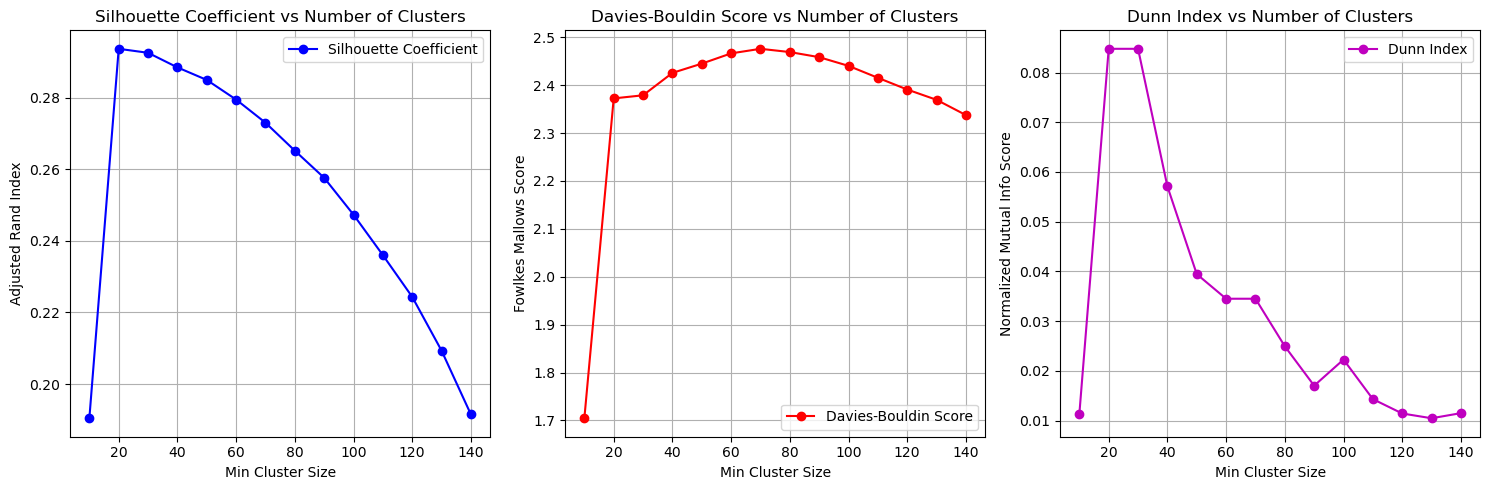

In [24]:
list_k = list(range(10, 150, 10))
silhouette = []
d_b = []
dunn_scores = []

for i in list_k:
    hdbscan_model = hdbscan(min_cluster_size=i)
    hdbscan_model.fit(sample)
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))

    s_score = silhouette_score(sample, hdbscan_labels)
    db_score = davies_bouldin_score(sample, hdbscan_labels)
    dunn_score = dunn_index(sample, hdbscan_labels)

    silhouette.append(s_score)
    d_b.append(db_score)
    dunn_scores.append(dunn_score)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(list_k, silhouette, marker='o', linestyle='-', color='b', label="Silhouette Coefficient")
ax[0].set_title('Silhouette Coefficient vs Number of Clusters')
ax[0].set_xlabel('Min Cluster Size')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(list_k, d_b, marker='o', linestyle='-', color='r', label="Davies-Bouldin Score")
ax[1].set_title('Davies-Bouldin Score vs Number of Clusters')
ax[1].set_xlabel('Min Cluster Size')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(list_k, dunn_scores, marker='o', linestyle='-', color='m', label="Dunn Index")
ax[2].set_title('Dunn Index vs Number of Clusters')
ax[2].set_xlabel('Min Cluster Size')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


Min Cluster size 10 number of clusters: 149
Min Cluster size 20 number of clusters: 17
Min Cluster size 30 number of clusters: 17
Min Cluster size 40 number of clusters: 17
Min Cluster size 50 number of clusters: 17
Min Cluster size 60 number of clusters: 17
Min Cluster size 70 number of clusters: 17
Min Cluster size 80 number of clusters: 17
Min Cluster size 90 number of clusters: 17
Min Cluster size 100 number of clusters: 17
Min Cluster size 110 number of clusters: 17
Min Cluster size 120 number of clusters: 17
Min Cluster size 130 number of clusters: 17
Min Cluster size 140 number of clusters: 17


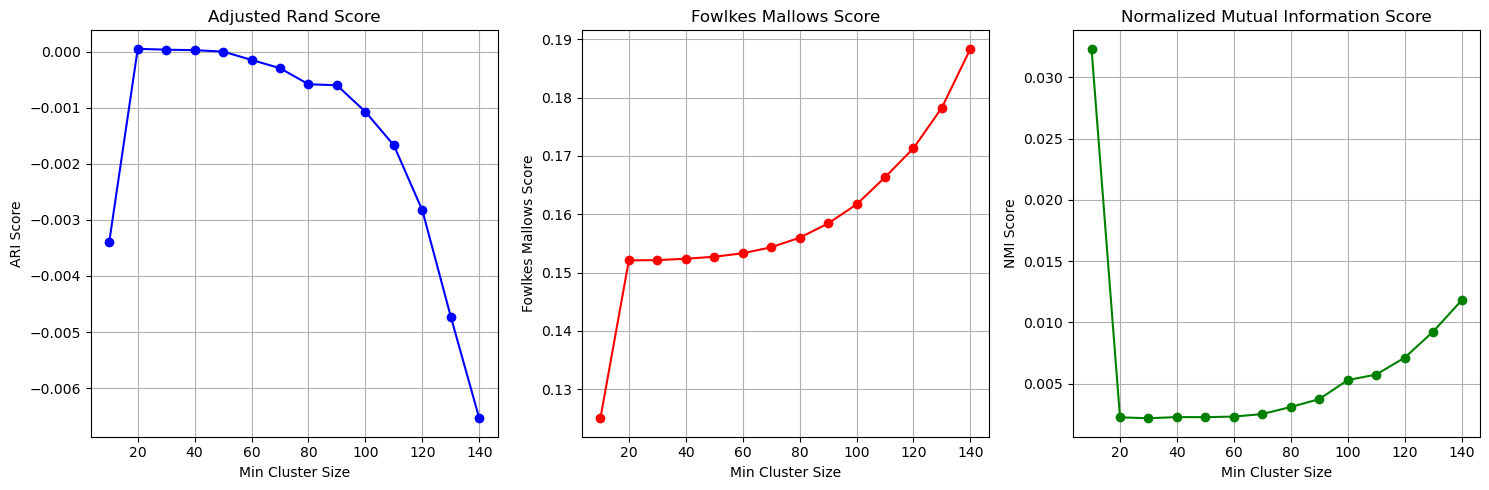

In [25]:
list_k = list(range(10, 150, 10))
ari = []
fowlkes_mallows = []
nmi = []

for i in list_k:
    hdbscan_model = hdbscan(min_cluster_size=i)
    hdbscan_model.fit(sample)
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))

    ari_score = adjusted_rand_score(target, hdbscan_labels)
    fm_score = fowlkes_mallows_score(target, hdbscan_labels)
    nmi_score = normalized_mutual_info_score(target, hdbscan_labels)
    

    ari.append(ari_score)
    fowlkes_mallows.append(fm_score)
    nmi.append(nmi_score)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')


# Plotting the elbow curve
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(list_k, ari, marker='o', linestyle='-', color='b', label="Adjusted Rand Score")
ax[0].set_title('Adjusted Rand Score')
ax[0].set_xlabel('Min Cluster Size')
ax[0].set_ylabel('ARI Score')
ax[0].grid(True)

# Plot Fowlkes Mallows Score
ax[1].plot(list_k, fowlkes_mallows, marker='o', linestyle='-', color='r', label="Fowlkes Mallows Score")
ax[1].set_title('Fowlkes Mallows Score')
ax[1].set_xlabel('Min Cluster Size')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)

# Plot Normalized Mutual Information Score
ax[2].plot(list_k, nmi, marker='o', linestyle='-', color='g', label="Normalized Mutual Information Score")
ax[2].set_title('Normalized Mutual Information Score')
ax[2].set_xlabel('Min Cluster Size')
ax[2].set_ylabel('NMI Score')
ax[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Min Cluster size 0.1 number of clusters: 251
Min Cluster size 0.2 number of clusters: 251
Min Cluster size 0.3 number of clusters: 251
Min Cluster size 0.5 number of clusters: 251
Min Cluster size 0.7 number of clusters: 251
Min Cluster size 1.0 number of clusters: 251


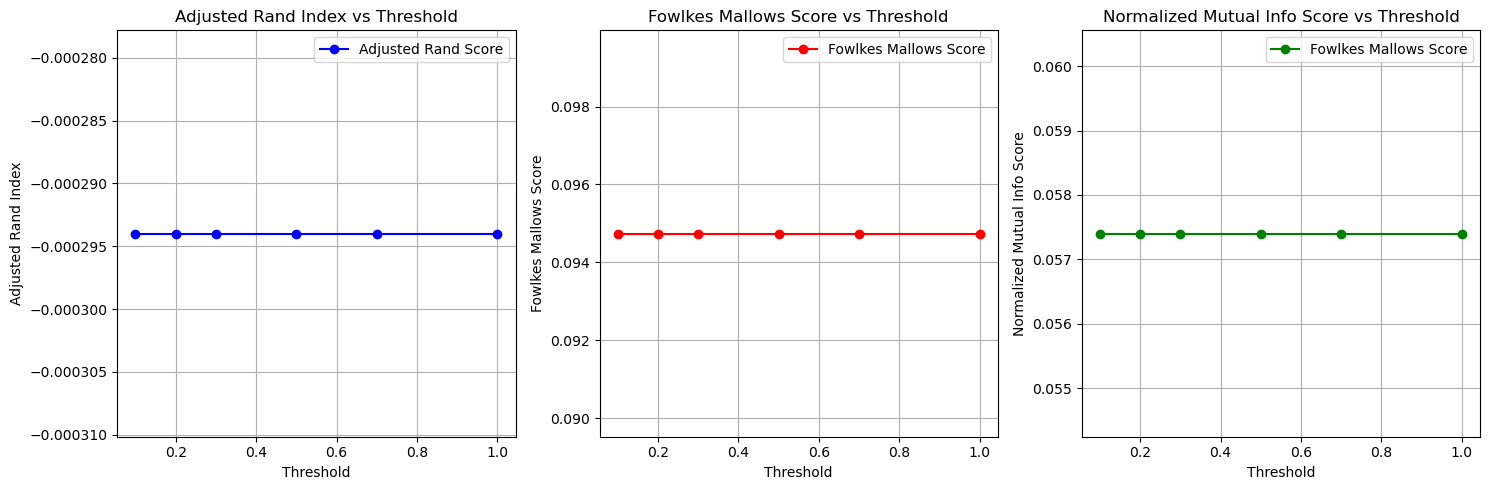

In [26]:
thresholds = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
ari = []
fowlkes_mallows = []
nmi = []

# Loop over thresholds and calculate the ARI and Fowlkes-Mallows scores
for i in thresholds:
    hdbscan_model = hdbscan(cluster_selection_epsilon=i)
    hdbscan_model.fit(sample) 
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))


    ari_score = adjusted_rand_score(target, hdbscan_labels)
    fm_score = fowlkes_mallows_score(target, hdbscan_labels)
    nmi_score = normalized_mutual_info_score(target, hdbscan_labels)

    
    ari.append(ari_score)
    fowlkes_mallows.append(fm_score)
    nmi.append(nmi_score)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')


# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(thresholds, ari, marker='o', linestyle='-', color='b', label="Adjusted Rand Score")
ax[0].set_title('Adjusted Rand Index vs Threshold')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(thresholds, fowlkes_mallows, marker='o', linestyle='-', color='r', label="Fowlkes Mallows Score")
ax[1].set_title('Fowlkes Mallows Score vs Threshold')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(thresholds, nmi, marker='o', linestyle='-', color='g', label="Fowlkes Mallows Score")
ax[2].set_title('Normalized Mutual Info Score vs Threshold')
ax[2].set_xlabel('Threshold')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


Min Cluster size 10 number of clusters: 251
Min Cluster size 20 number of clusters: 251
Min Cluster size 30 number of clusters: 251
Min Cluster size 40 number of clusters: 251
Min Cluster size 50 number of clusters: 251
Min Cluster size 60 number of clusters: 251
Min Cluster size 70 number of clusters: 251
Min Cluster size 80 number of clusters: 251
Min Cluster size 90 number of clusters: 251
Min Cluster size 100 number of clusters: 251


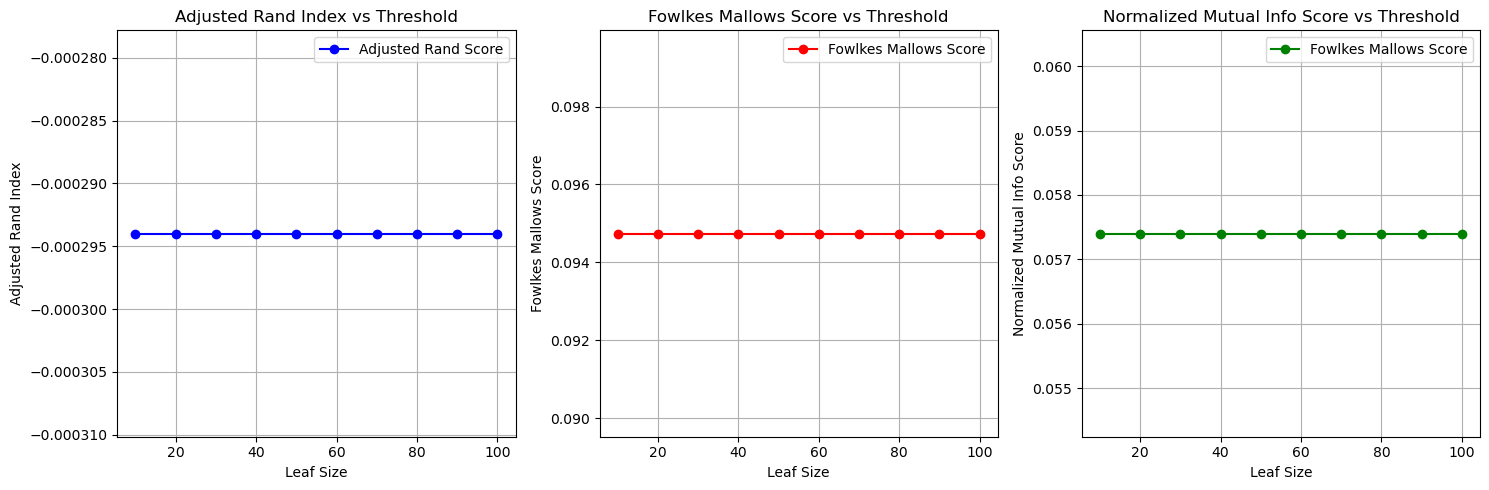

In [27]:
leaf_size = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ari = []
fowlkes_mallows = []
nmi = []



for i in leaf_size:
    hdbscan_model = hdbscan(leaf_size=i)
    hdbscan_model.fit(sample) 
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))


    ari_score = adjusted_rand_score(target, hdbscan_labels)
    fm_score = fowlkes_mallows_score(target, hdbscan_labels)
    nmi_score = normalized_mutual_info_score(target, hdbscan_labels)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')

    
    ari.append(ari_score)
    fowlkes_mallows.append(fm_score)
    nmi.append(nmi_score)


# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(leaf_size, ari, marker='o', linestyle='-', color='b', label="Adjusted Rand Score")
ax[0].set_title('Adjusted Rand Index vs Threshold')
ax[0].set_xlabel('Leaf Size')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(leaf_size, fowlkes_mallows, marker='o', linestyle='-', color='r', label="Fowlkes Mallows Score")
ax[1].set_title('Fowlkes Mallows Score vs Threshold')
ax[1].set_xlabel('Leaf Size')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(leaf_size, nmi, marker='o', linestyle='-', color='g', label="Fowlkes Mallows Score")
ax[2].set_title('Normalized Mutual Info Score vs Threshold')
ax[2].set_xlabel('Leaf Size')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


In [28]:
sample_no_target = sample.drop(columns='Credit_Score')
sample_no_target.head()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month,Occupation_Accountant,Occupation_Architect,...,Payment_of_Min_Amount_NM,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_!@9#%8,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
0,1.045603,-0.102200,-0.144813,-0.135537,-1.399734,-0.135365,0.495214,-0.156040,-0.249042,-0.259738,...,-0.356569,1.304877,-1.035013,-0.277708,-0.398433,2.177275,-0.338495,-0.339228,-0.412810,-0.601378
1,-0.723602,0.789450,-0.152536,-0.156002,-0.595443,-0.130752,0.492101,-0.155398,-0.249042,-0.259738,...,-0.356569,1.304877,-1.035013,-0.277708,-0.398433,-0.459290,-0.338495,-0.339228,-0.412810,1.662847
2,-0.848648,-0.130357,-0.144813,-0.158049,-0.863540,-0.130752,-0.115821,-0.155481,-0.249042,-0.259738,...,-0.356569,1.304877,-1.035013,-0.277708,-0.398433,-0.459290,-0.338495,-0.339228,2.422423,-0.601378
3,-0.392563,-0.092814,-0.129367,-0.125304,0.074799,-0.135365,0.358234,-0.159635,-0.249042,-0.259738,...,-0.356569,-0.766356,0.966172,-0.277708,-0.398433,-0.459290,-0.338495,-0.339228,-0.412810,1.662847
4,1.764811,-0.130357,-0.137090,-0.139630,-0.729492,-0.126140,0.888081,-0.142237,-0.249042,-0.259738,...,2.804505,-0.766356,-1.035013,-0.277708,-0.398433,2.177275,-0.338495,-0.339228,-0.412810,-0.601378


Min Cluster size 10 number of clusters: 176
Min Cluster size 20 number of clusters: 27
Min Cluster size 30 number of clusters: 17
Min Cluster size 40 number of clusters: 17
Min Cluster size 50 number of clusters: 17
Min Cluster size 60 number of clusters: 17
Min Cluster size 70 number of clusters: 17
Min Cluster size 80 number of clusters: 17
Min Cluster size 90 number of clusters: 17
Min Cluster size 100 number of clusters: 17
Min Cluster size 110 number of clusters: 17
Min Cluster size 120 number of clusters: 17
Min Cluster size 130 number of clusters: 17
Min Cluster size 140 number of clusters: 17


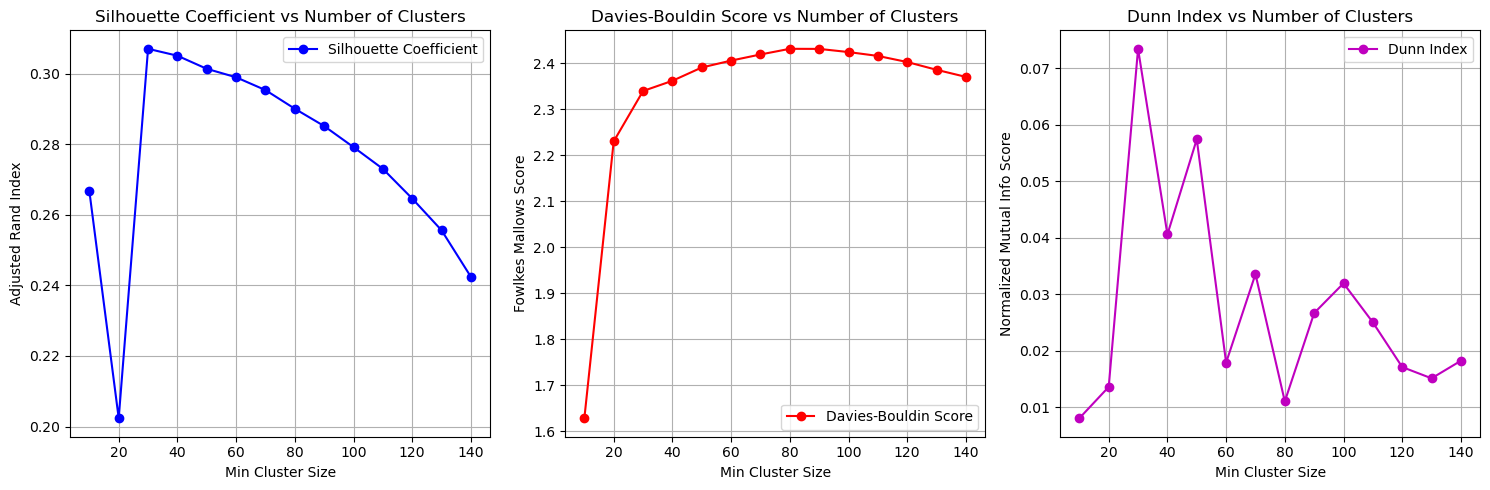

In [29]:
list_k = list(range(10, 150, 10))
silhouette = []
d_b = []
dunn_scores = []

for i in list_k:
    hdbscan_model = hdbscan(min_cluster_size=i)
    hdbscan_model.fit(sample_no_target)
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))

    s_score = silhouette_score(sample_no_target, hdbscan_labels)
    db_score = davies_bouldin_score(sample_no_target, hdbscan_labels)
    dunn_score = dunn_index(sample_no_target, hdbscan_labels)

    silhouette.append(s_score)
    d_b.append(db_score)
    dunn_scores.append(dunn_score)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(list_k, silhouette, marker='o', linestyle='-', color='b', label="Silhouette Coefficient")
ax[0].set_title('Silhouette Coefficient vs Number of Clusters')
ax[0].set_xlabel('Min Cluster Size')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(list_k, d_b, marker='o', linestyle='-', color='r', label="Davies-Bouldin Score")
ax[1].set_title('Davies-Bouldin Score vs Number of Clusters')
ax[1].set_xlabel('Min Cluster Size')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(list_k, dunn_scores, marker='o', linestyle='-', color='m', label="Dunn Index")
ax[2].set_title('Dunn Index vs Number of Clusters')
ax[2].set_xlabel('Min Cluster Size')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


Min Cluster size 10 number of clusters: 176
Min Cluster size 20 number of clusters: 27
Min Cluster size 30 number of clusters: 17
Min Cluster size 40 number of clusters: 17
Min Cluster size 50 number of clusters: 17
Min Cluster size 60 number of clusters: 17
Min Cluster size 70 number of clusters: 17
Min Cluster size 80 number of clusters: 17
Min Cluster size 90 number of clusters: 17
Min Cluster size 100 number of clusters: 17
Min Cluster size 110 number of clusters: 17
Min Cluster size 120 number of clusters: 17
Min Cluster size 130 number of clusters: 17
Min Cluster size 140 number of clusters: 17


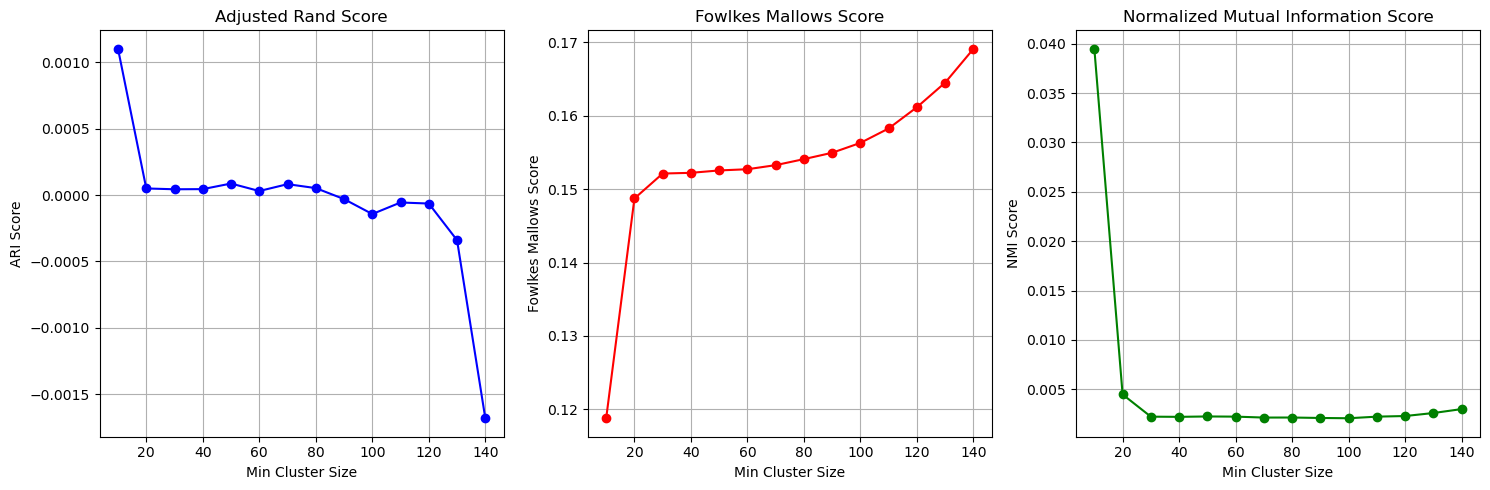

In [30]:
list_k = list(range(10, 150, 10))
ari = []
fowlkes_mallows = []
nmi = []

for i in list_k:
    hdbscan_model = hdbscan(min_cluster_size=i)
    hdbscan_model.fit(sample_no_target)
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))

    ari_score = adjusted_rand_score(target, hdbscan_labels)
    fm_score = fowlkes_mallows_score(target, hdbscan_labels)
    nmi_score = normalized_mutual_info_score(target, hdbscan_labels)
    

    ari.append(ari_score)
    fowlkes_mallows.append(fm_score)
    nmi.append(nmi_score)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')


# Plotting the elbow curve
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(list_k, ari, marker='o', linestyle='-', color='b', label="Adjusted Rand Score")
ax[0].set_title('Adjusted Rand Score')
ax[0].set_xlabel('Min Cluster Size')
ax[0].set_ylabel('ARI Score')
ax[0].grid(True)

# Plot Fowlkes Mallows Score
ax[1].plot(list_k, fowlkes_mallows, marker='o', linestyle='-', color='r', label="Fowlkes Mallows Score")
ax[1].set_title('Fowlkes Mallows Score')
ax[1].set_xlabel('Min Cluster Size')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)

# Plot Normalized Mutual Information Score
ax[2].plot(list_k, nmi, marker='o', linestyle='-', color='g', label="Normalized Mutual Information Score")
ax[2].set_title('Normalized Mutual Information Score')
ax[2].set_xlabel('Min Cluster Size')
ax[2].set_ylabel('NMI Score')
ax[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Min Cluster size 0.1 number of clusters: 258
Min Cluster size 0.2 number of clusters: 258
Min Cluster size 0.3 number of clusters: 258
Min Cluster size 0.5 number of clusters: 258
Min Cluster size 0.7 number of clusters: 258
Min Cluster size 1.0 number of clusters: 258


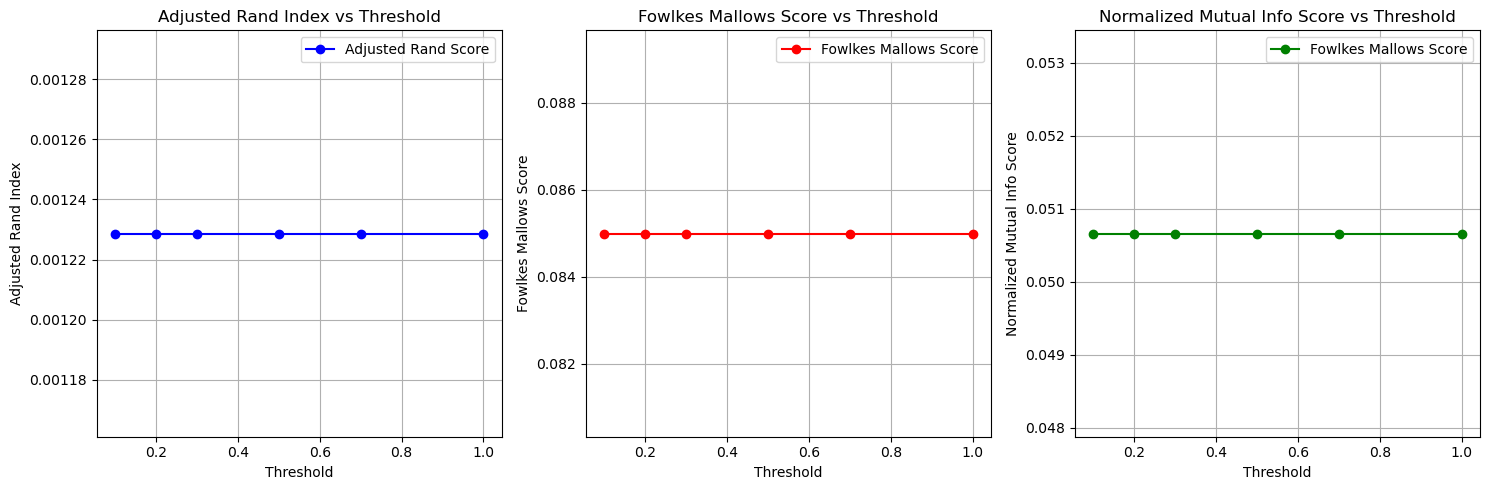

In [31]:
thresholds = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
ari = []
fowlkes_mallows = []
nmi = []

# Loop over thresholds and calculate the ARI and Fowlkes-Mallows scores
for i in thresholds:
    hdbscan_model = hdbscan(cluster_selection_epsilon=i)
    hdbscan_model.fit(sample_no_target) 
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))


    ari_score = adjusted_rand_score(target, hdbscan_labels)
    fm_score = fowlkes_mallows_score(target, hdbscan_labels)
    nmi_score = normalized_mutual_info_score(target, hdbscan_labels)

    
    ari.append(ari_score)
    fowlkes_mallows.append(fm_score)
    nmi.append(nmi_score)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')


# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(thresholds, ari, marker='o', linestyle='-', color='b', label="Adjusted Rand Score")
ax[0].set_title('Adjusted Rand Index vs Threshold')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(thresholds, fowlkes_mallows, marker='o', linestyle='-', color='r', label="Fowlkes Mallows Score")
ax[1].set_title('Fowlkes Mallows Score vs Threshold')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(thresholds, nmi, marker='o', linestyle='-', color='g', label="Fowlkes Mallows Score")
ax[2].set_title('Normalized Mutual Info Score vs Threshold')
ax[2].set_xlabel('Threshold')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


Min Cluster size 10 number of clusters: 258
Min Cluster size 20 number of clusters: 258
Min Cluster size 30 number of clusters: 258
Min Cluster size 40 number of clusters: 258
Min Cluster size 50 number of clusters: 258
Min Cluster size 60 number of clusters: 258
Min Cluster size 70 number of clusters: 258
Min Cluster size 80 number of clusters: 258
Min Cluster size 90 number of clusters: 258
Min Cluster size 100 number of clusters: 258


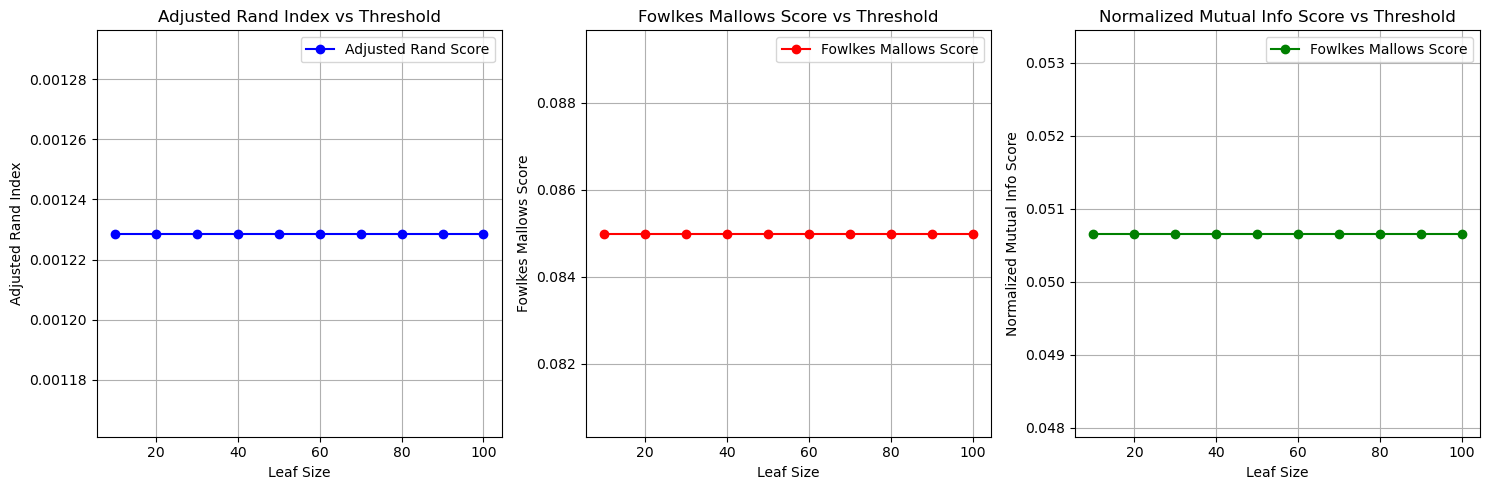

In [32]:
leaf_size = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ari = []
fowlkes_mallows = []
nmi = []



for i in leaf_size:
    hdbscan_model = hdbscan(leaf_size=i)
    hdbscan_model.fit(sample_no_target) 
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))


    ari_score = adjusted_rand_score(target, hdbscan_labels)
    fm_score = fowlkes_mallows_score(target, hdbscan_labels)
    nmi_score = normalized_mutual_info_score(target, hdbscan_labels)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')

    
    ari.append(ari_score)
    fowlkes_mallows.append(fm_score)
    nmi.append(nmi_score)


# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(leaf_size, ari, marker='o', linestyle='-', color='b', label="Adjusted Rand Score")
ax[0].set_title('Adjusted Rand Index vs Threshold')
ax[0].set_xlabel('Leaf Size')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(leaf_size, fowlkes_mallows, marker='o', linestyle='-', color='r', label="Fowlkes Mallows Score")
ax[1].set_title('Fowlkes Mallows Score vs Threshold')
ax[1].set_xlabel('Leaf Size')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(leaf_size, nmi, marker='o', linestyle='-', color='g', label="Fowlkes Mallows Score")
ax[2].set_title('Normalized Mutual Info Score vs Threshold')
ax[2].set_xlabel('Leaf Size')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


In [33]:
iris = pd.read_csv('./iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [34]:
le = preprocessing.LabelEncoder()
le.fit(iris['species'])
iris['species'] = le.transform(iris['species'])
iris['species'].unique()

array([0, 1, 2])

Min Cluster size 10 number of clusters: 4
Min Cluster size 20 number of clusters: 2
Min Cluster size 30 number of clusters: 3
Min Cluster size 40 number of clusters: 3
Min Cluster size 50 number of clusters: 1
Min Cluster size 60 number of clusters: 1
Min Cluster size 70 number of clusters: 1
Min Cluster size 80 number of clusters: 1
Min Cluster size 90 number of clusters: 1
Min Cluster size 100 number of clusters: 1
Min Cluster size 110 number of clusters: 1
Min Cluster size 120 number of clusters: 1
Min Cluster size 130 number of clusters: 1
Min Cluster size 140 number of clusters: 1


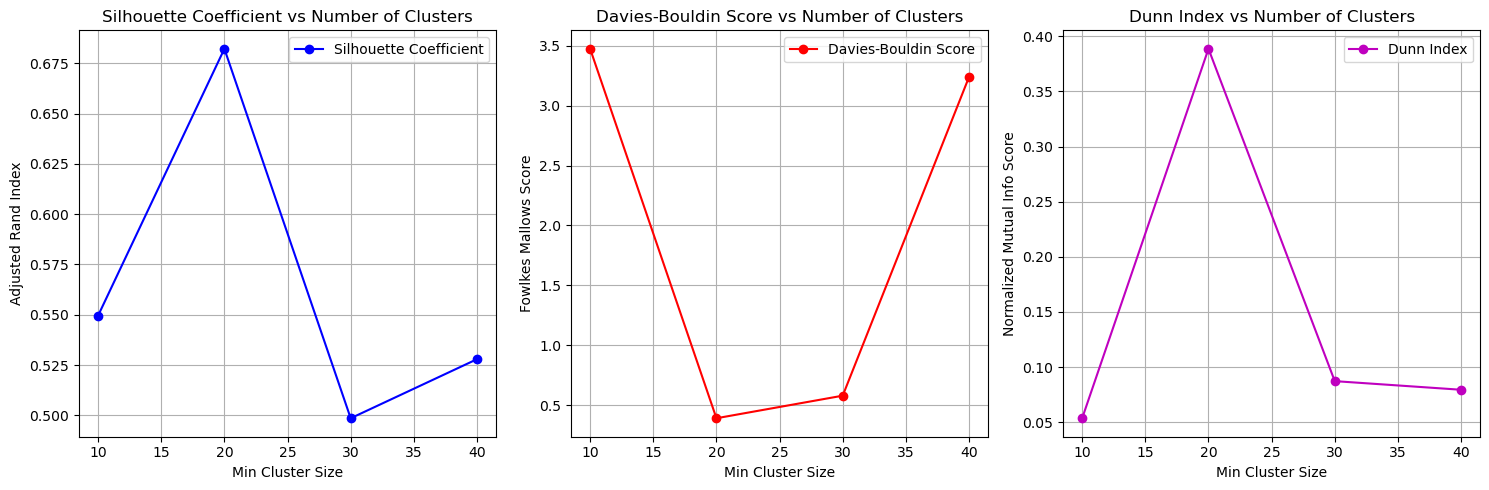

In [35]:
list_k = list(range(10, 150, 10))
silhouette = []
d_b = []
dunn_scores = []

for i in list_k:
    hdbscan_model = hdbscan(min_cluster_size=i)
    hdbscan_model.fit(iris)
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))

    if k_clusters > 1:
        s_score = silhouette_score(iris, hdbscan_labels)
        db_score = davies_bouldin_score(iris, hdbscan_labels)
        dunn_score = dunn_index(iris, hdbscan_labels)  # Assuming dunn_index is defined
    
        silhouette.append(s_score)
        d_b.append(db_score)
        dunn_scores.append(dunn_score)
    else:
        silhouette.append(np.nan)  # Append NaN for invalid clusters
        d_b.append(np.nan)
        dunn_scores.append(np.nan)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(list_k, silhouette, marker='o', linestyle='-', color='b', label="Silhouette Coefficient")
ax[0].set_title('Silhouette Coefficient vs Number of Clusters')
ax[0].set_xlabel('Min Cluster Size')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(list_k, d_b, marker='o', linestyle='-', color='r', label="Davies-Bouldin Score")
ax[1].set_title('Davies-Bouldin Score vs Number of Clusters')
ax[1].set_xlabel('Min Cluster Size')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(list_k, dunn_scores, marker='o', linestyle='-', color='m', label="Dunn Index")
ax[2].set_title('Dunn Index vs Number of Clusters')
ax[2].set_xlabel('Min Cluster Size')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


Min Cluster size 10 number of clusters: 4
Min Cluster size 20 number of clusters: 2
Min Cluster size 30 number of clusters: 3
Min Cluster size 40 number of clusters: 3
Min Cluster size 50 number of clusters: 1
Min Cluster size 60 number of clusters: 1
Min Cluster size 70 number of clusters: 1
Min Cluster size 80 number of clusters: 1
Min Cluster size 90 number of clusters: 1
Min Cluster size 100 number of clusters: 1
Min Cluster size 110 number of clusters: 1
Min Cluster size 120 number of clusters: 1
Min Cluster size 130 number of clusters: 1
Min Cluster size 140 number of clusters: 1


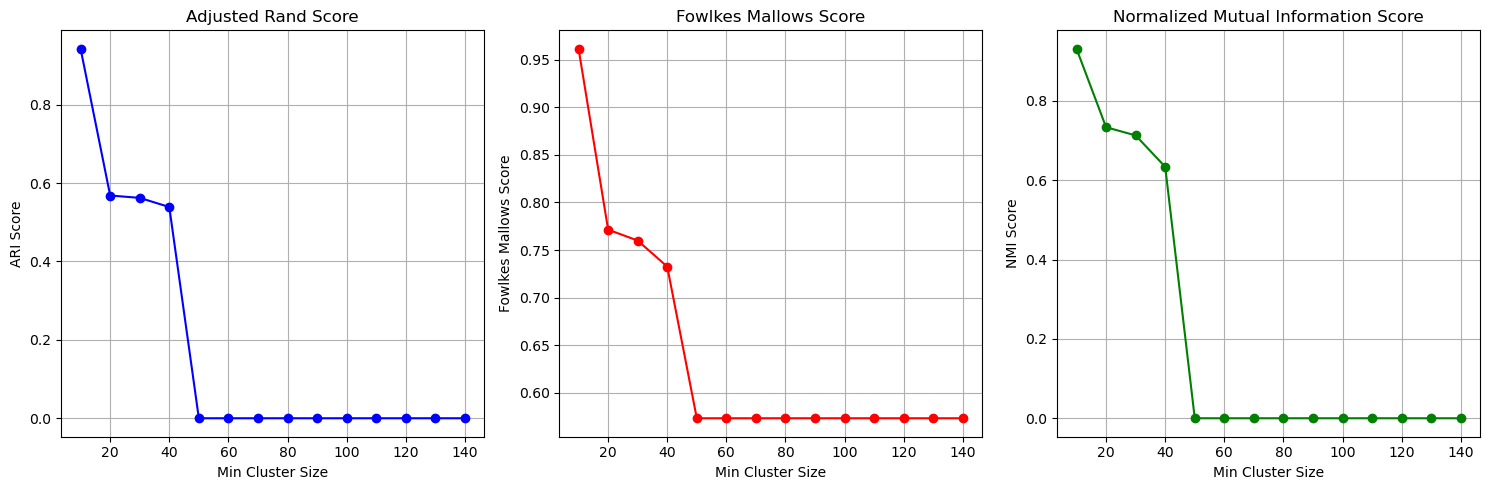

In [36]:
list_k = list(range(10, 150, 10))
ari = []
fowlkes_mallows = []
nmi = []

for i in list_k:
    hdbscan_model = hdbscan(min_cluster_size=i)
    hdbscan_model.fit(iris)
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))

    ari_score = adjusted_rand_score(iris['species'], hdbscan_labels)
    fm_score = fowlkes_mallows_score(iris['species'], hdbscan_labels)
    nmi_score = normalized_mutual_info_score(iris['species'], hdbscan_labels)
    

    ari.append(ari_score)
    fowlkes_mallows.append(fm_score)
    nmi.append(nmi_score)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')


# Plotting the elbow curve
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(list_k, ari, marker='o', linestyle='-', color='b', label="Adjusted Rand Score")
ax[0].set_title('Adjusted Rand Score')
ax[0].set_xlabel('Min Cluster Size')
ax[0].set_ylabel('ARI Score')
ax[0].grid(True)

# Plot Fowlkes Mallows Score
ax[1].plot(list_k, fowlkes_mallows, marker='o', linestyle='-', color='r', label="Fowlkes Mallows Score")
ax[1].set_title('Fowlkes Mallows Score')
ax[1].set_xlabel('Min Cluster Size')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)

# Plot Normalized Mutual Information Score
ax[2].plot(list_k, nmi, marker='o', linestyle='-', color='g', label="Normalized Mutual Information Score")
ax[2].set_title('Normalized Mutual Information Score')
ax[2].set_xlabel('Min Cluster Size')
ax[2].set_ylabel('NMI Score')
ax[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Min Cluster size 0.1 number of clusters: 4
Min Cluster size 0.2 number of clusters: 4
Min Cluster size 0.3 number of clusters: 4
Min Cluster size 0.5 number of clusters: 4
Min Cluster size 0.7 number of clusters: 4
Min Cluster size 1.0 number of clusters: 4


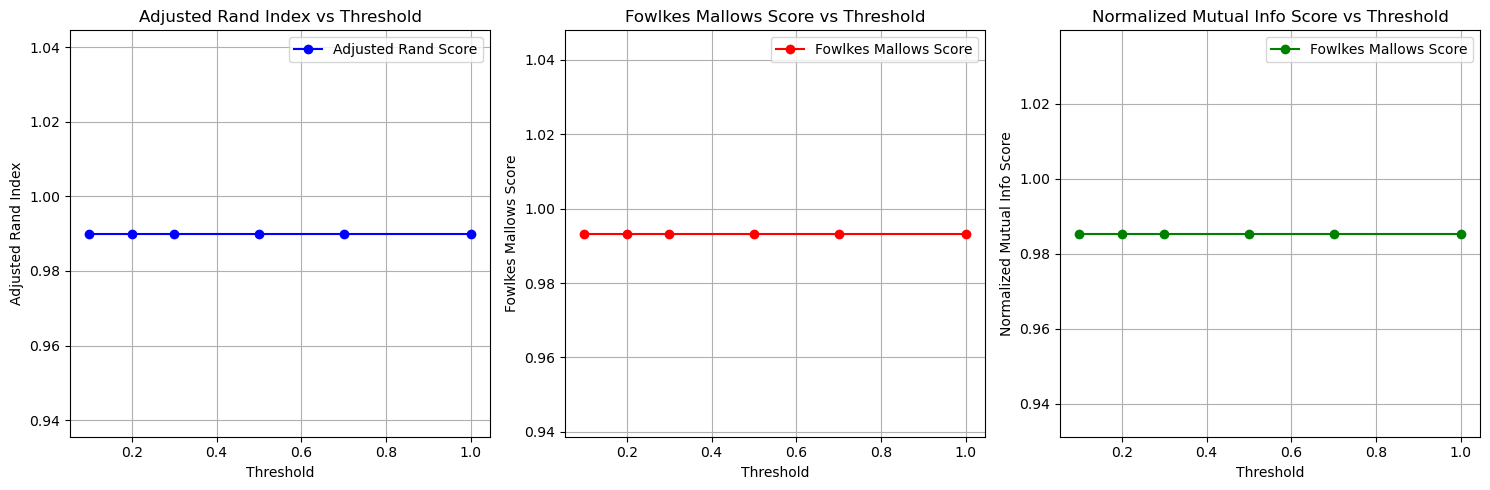

In [37]:
thresholds = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
ari = []
fowlkes_mallows = []
nmi = []

# Loop over thresholds and calculate the ARI and Fowlkes-Mallows scores
for i in thresholds:
    hdbscan_model = hdbscan(cluster_selection_epsilon=i)
    hdbscan_model.fit(iris) 
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))


    ari_score = adjusted_rand_score(iris['species'], hdbscan_labels)
    fm_score = fowlkes_mallows_score(iris['species'], hdbscan_labels)
    nmi_score = normalized_mutual_info_score(iris['species'], hdbscan_labels)

    
    ari.append(ari_score)
    fowlkes_mallows.append(fm_score)
    nmi.append(nmi_score)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')


# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(thresholds, ari, marker='o', linestyle='-', color='b', label="Adjusted Rand Score")
ax[0].set_title('Adjusted Rand Index vs Threshold')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(thresholds, fowlkes_mallows, marker='o', linestyle='-', color='r', label="Fowlkes Mallows Score")
ax[1].set_title('Fowlkes Mallows Score vs Threshold')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(thresholds, nmi, marker='o', linestyle='-', color='g', label="Fowlkes Mallows Score")
ax[2].set_title('Normalized Mutual Info Score vs Threshold')
ax[2].set_xlabel('Threshold')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


Min Cluster size 10 number of clusters: 4
Min Cluster size 20 number of clusters: 4
Min Cluster size 30 number of clusters: 4
Min Cluster size 40 number of clusters: 4
Min Cluster size 50 number of clusters: 4
Min Cluster size 60 number of clusters: 4
Min Cluster size 70 number of clusters: 4
Min Cluster size 80 number of clusters: 4
Min Cluster size 90 number of clusters: 4
Min Cluster size 100 number of clusters: 4


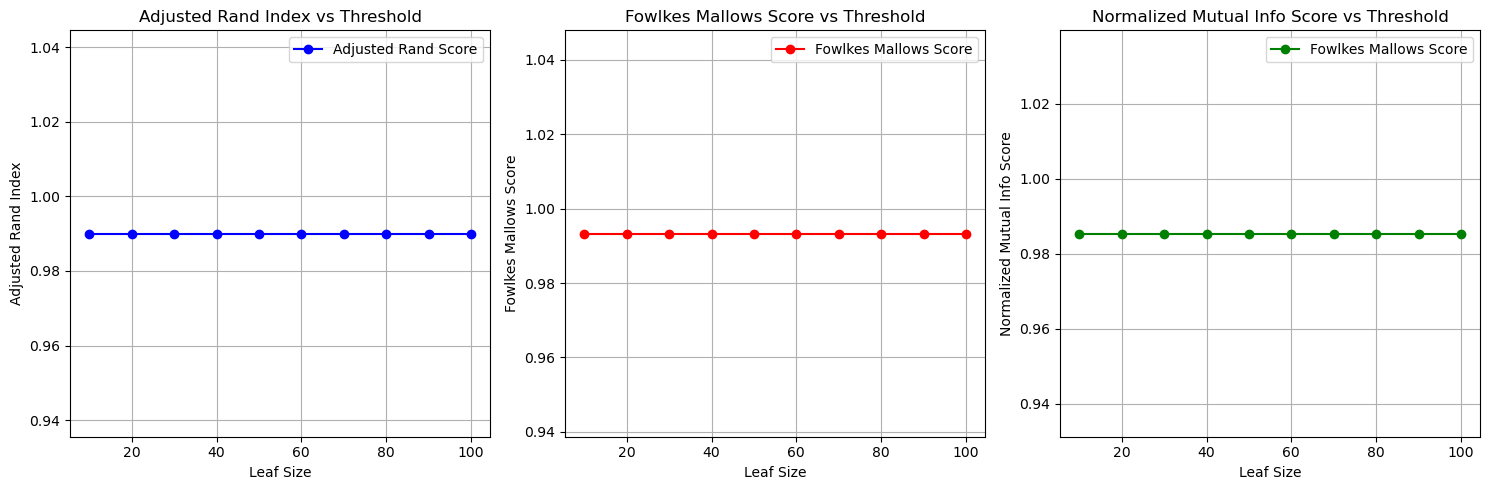

In [38]:
leaf_size = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ari = []
fowlkes_mallows = []
nmi = []



for i in leaf_size:
    hdbscan_model = hdbscan(leaf_size=i)
    hdbscan_model.fit(iris) 
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))


    ari_score = adjusted_rand_score(iris['species'], hdbscan_labels)
    fm_score = fowlkes_mallows_score(iris['species'], hdbscan_labels)
    nmi_score = normalized_mutual_info_score(iris['species'], hdbscan_labels)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')

    
    ari.append(ari_score)
    fowlkes_mallows.append(fm_score)
    nmi.append(nmi_score)


# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(leaf_size, ari, marker='o', linestyle='-', color='b', label="Adjusted Rand Score")
ax[0].set_title('Adjusted Rand Index vs Threshold')
ax[0].set_xlabel('Leaf Size')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(leaf_size, fowlkes_mallows, marker='o', linestyle='-', color='r', label="Fowlkes Mallows Score")
ax[1].set_title('Fowlkes Mallows Score vs Threshold')
ax[1].set_xlabel('Leaf Size')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(leaf_size, nmi, marker='o', linestyle='-', color='g', label="Fowlkes Mallows Score")
ax[2].set_title('Normalized Mutual Info Score vs Threshold')
ax[2].set_xlabel('Leaf Size')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


In [39]:
iris_no_target = iris.drop(columns=['species'])
iris_no_target.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Min Cluster size 10 number of clusters: 2
Min Cluster size 20 number of clusters: 3
Min Cluster size 30 number of clusters: 3
Min Cluster size 40 number of clusters: 3
Min Cluster size 50 number of clusters: 1
Min Cluster size 60 number of clusters: 1
Min Cluster size 70 number of clusters: 1
Min Cluster size 80 number of clusters: 1
Min Cluster size 90 number of clusters: 1
Min Cluster size 100 number of clusters: 1
Min Cluster size 110 number of clusters: 1
Min Cluster size 120 number of clusters: 1
Min Cluster size 130 number of clusters: 1
Min Cluster size 140 number of clusters: 1


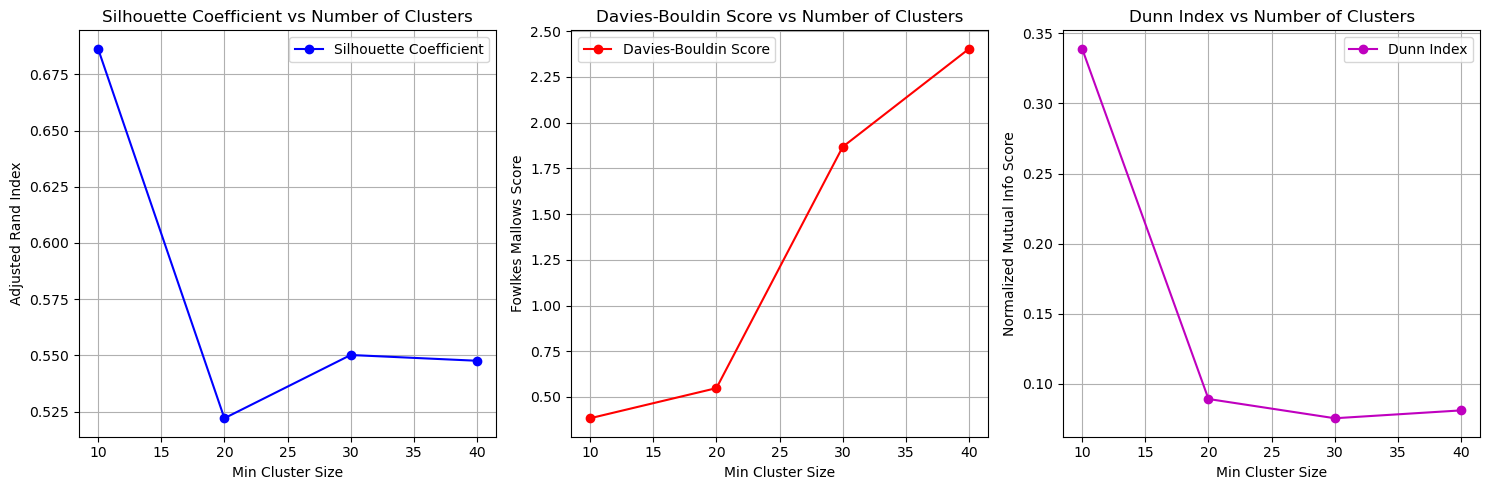

In [40]:
list_k = list(range(10, 150, 10))
silhouette = []
d_b = []
dunn_scores = []

for i in list_k:
    hdbscan_model = hdbscan(min_cluster_size=i)
    hdbscan_model.fit(iris_no_target)
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))

    if k_clusters > 1:
        s_score = silhouette_score(iris_no_target, hdbscan_labels)
        db_score = davies_bouldin_score(iris_no_target, hdbscan_labels)
        dunn_score = dunn_index(iris_no_target, hdbscan_labels)  # Assuming dunn_index is defined
    
        silhouette.append(s_score)
        d_b.append(db_score)
        dunn_scores.append(dunn_score)
    else:
        silhouette.append(np.nan)  # Append NaN for invalid clusters
        d_b.append(np.nan)
        dunn_scores.append(np.nan)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(list_k, silhouette, marker='o', linestyle='-', color='b', label="Silhouette Coefficient")
ax[0].set_title('Silhouette Coefficient vs Number of Clusters')
ax[0].set_xlabel('Min Cluster Size')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(list_k, d_b, marker='o', linestyle='-', color='r', label="Davies-Bouldin Score")
ax[1].set_title('Davies-Bouldin Score vs Number of Clusters')
ax[1].set_xlabel('Min Cluster Size')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(list_k, dunn_scores, marker='o', linestyle='-', color='m', label="Dunn Index")
ax[2].set_title('Dunn Index vs Number of Clusters')
ax[2].set_xlabel('Min Cluster Size')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


Min Cluster size 10 number of clusters: 2
Min Cluster size 20 number of clusters: 3
Min Cluster size 30 number of clusters: 3
Min Cluster size 40 number of clusters: 3
Min Cluster size 50 number of clusters: 1
Min Cluster size 60 number of clusters: 1
Min Cluster size 70 number of clusters: 1
Min Cluster size 80 number of clusters: 1
Min Cluster size 90 number of clusters: 1
Min Cluster size 100 number of clusters: 1
Min Cluster size 110 number of clusters: 1
Min Cluster size 120 number of clusters: 1
Min Cluster size 130 number of clusters: 1
Min Cluster size 140 number of clusters: 1


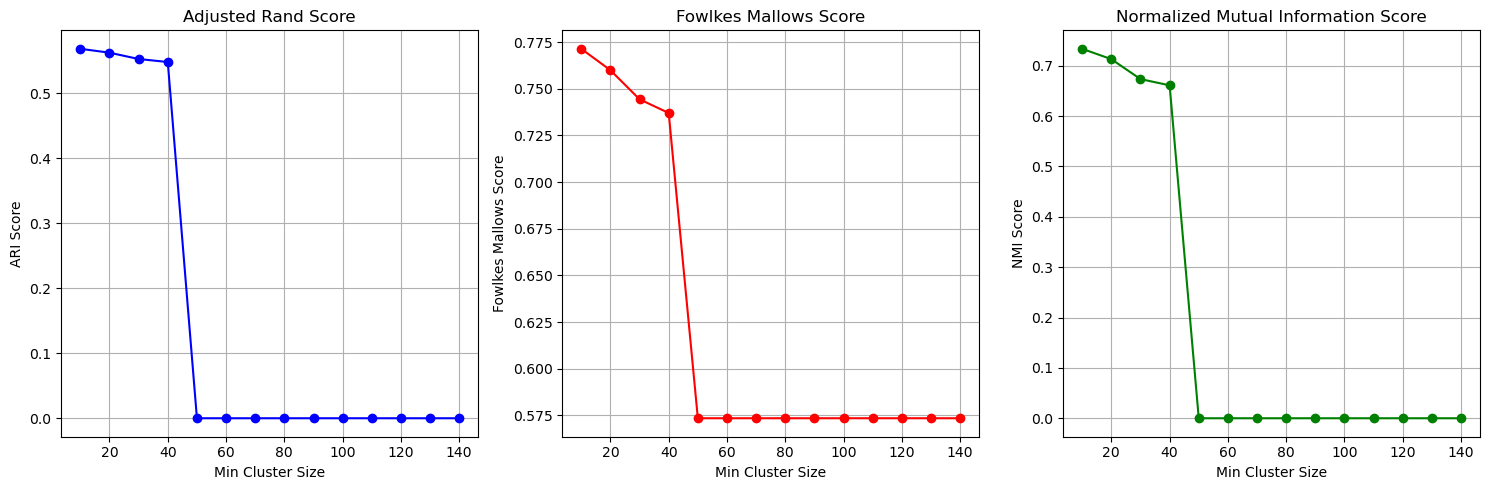

In [41]:
list_k = list(range(10, 150, 10))
ari = []
fowlkes_mallows = []
nmi = []

for i in list_k:
    hdbscan_model = hdbscan(min_cluster_size=i)
    hdbscan_model.fit(iris_no_target)
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))

    ari_score = adjusted_rand_score(iris['species'], hdbscan_labels)
    fm_score = fowlkes_mallows_score(iris['species'], hdbscan_labels)
    nmi_score = normalized_mutual_info_score(iris['species'], hdbscan_labels)
    

    ari.append(ari_score)
    fowlkes_mallows.append(fm_score)
    nmi.append(nmi_score)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')


# Plotting the elbow curve
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(list_k, ari, marker='o', linestyle='-', color='b', label="Adjusted Rand Score")
ax[0].set_title('Adjusted Rand Score')
ax[0].set_xlabel('Min Cluster Size')
ax[0].set_ylabel('ARI Score')
ax[0].grid(True)

# Plot Fowlkes Mallows Score
ax[1].plot(list_k, fowlkes_mallows, marker='o', linestyle='-', color='r', label="Fowlkes Mallows Score")
ax[1].set_title('Fowlkes Mallows Score')
ax[1].set_xlabel('Min Cluster Size')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)

# Plot Normalized Mutual Information Score
ax[2].plot(list_k, nmi, marker='o', linestyle='-', color='g', label="Normalized Mutual Information Score")
ax[2].set_title('Normalized Mutual Information Score')
ax[2].set_xlabel('Min Cluster Size')
ax[2].set_ylabel('NMI Score')
ax[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Min Cluster size 0.1 number of clusters: 2
Min Cluster size 0.2 number of clusters: 2
Min Cluster size 0.3 number of clusters: 2
Min Cluster size 0.5 number of clusters: 2
Min Cluster size 0.7 number of clusters: 2
Min Cluster size 1.0 number of clusters: 2


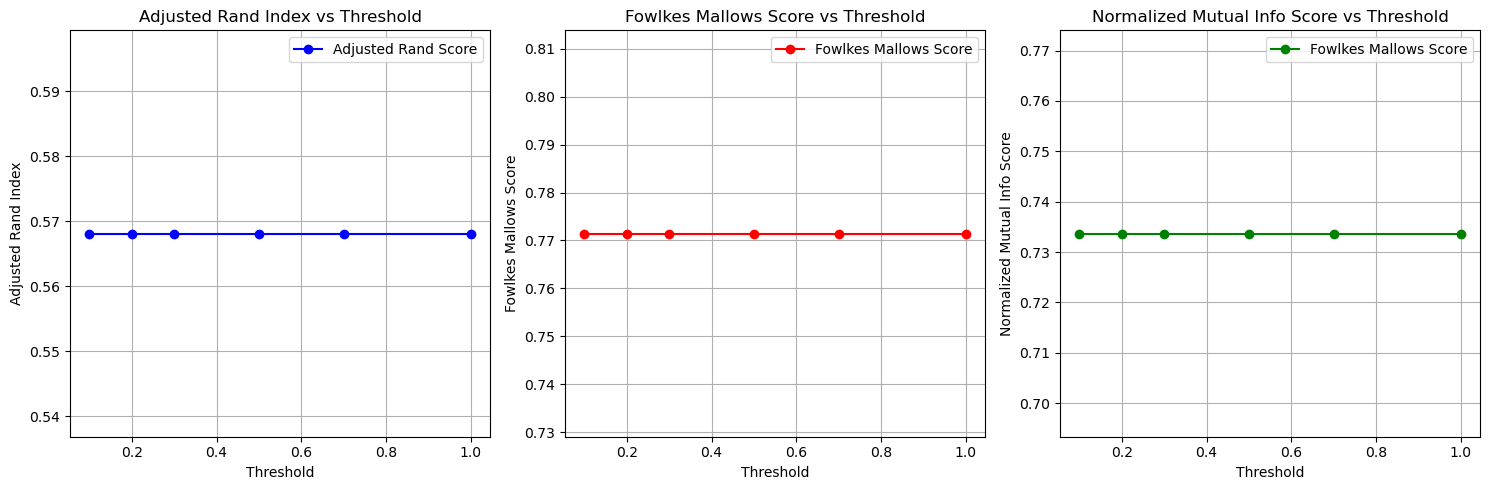

In [42]:
thresholds = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
ari = []
fowlkes_mallows = []
nmi = []

# Loop over thresholds and calculate the ARI and Fowlkes-Mallows scores
for i in thresholds:
    hdbscan_model = hdbscan(cluster_selection_epsilon=i)
    hdbscan_model.fit(iris_no_target) 
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))


    ari_score = adjusted_rand_score(iris['species'], hdbscan_labels)
    fm_score = fowlkes_mallows_score(iris['species'], hdbscan_labels)
    nmi_score = normalized_mutual_info_score(iris['species'], hdbscan_labels)

    
    ari.append(ari_score)
    fowlkes_mallows.append(fm_score)
    nmi.append(nmi_score)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')


# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(thresholds, ari, marker='o', linestyle='-', color='b', label="Adjusted Rand Score")
ax[0].set_title('Adjusted Rand Index vs Threshold')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(thresholds, fowlkes_mallows, marker='o', linestyle='-', color='r', label="Fowlkes Mallows Score")
ax[1].set_title('Fowlkes Mallows Score vs Threshold')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(thresholds, nmi, marker='o', linestyle='-', color='g', label="Fowlkes Mallows Score")
ax[2].set_title('Normalized Mutual Info Score vs Threshold')
ax[2].set_xlabel('Threshold')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


Min Cluster size 10 number of clusters: 2
Min Cluster size 20 number of clusters: 2
Min Cluster size 30 number of clusters: 2
Min Cluster size 40 number of clusters: 2
Min Cluster size 50 number of clusters: 2
Min Cluster size 60 number of clusters: 2
Min Cluster size 70 number of clusters: 2
Min Cluster size 80 number of clusters: 2
Min Cluster size 90 number of clusters: 2
Min Cluster size 100 number of clusters: 2


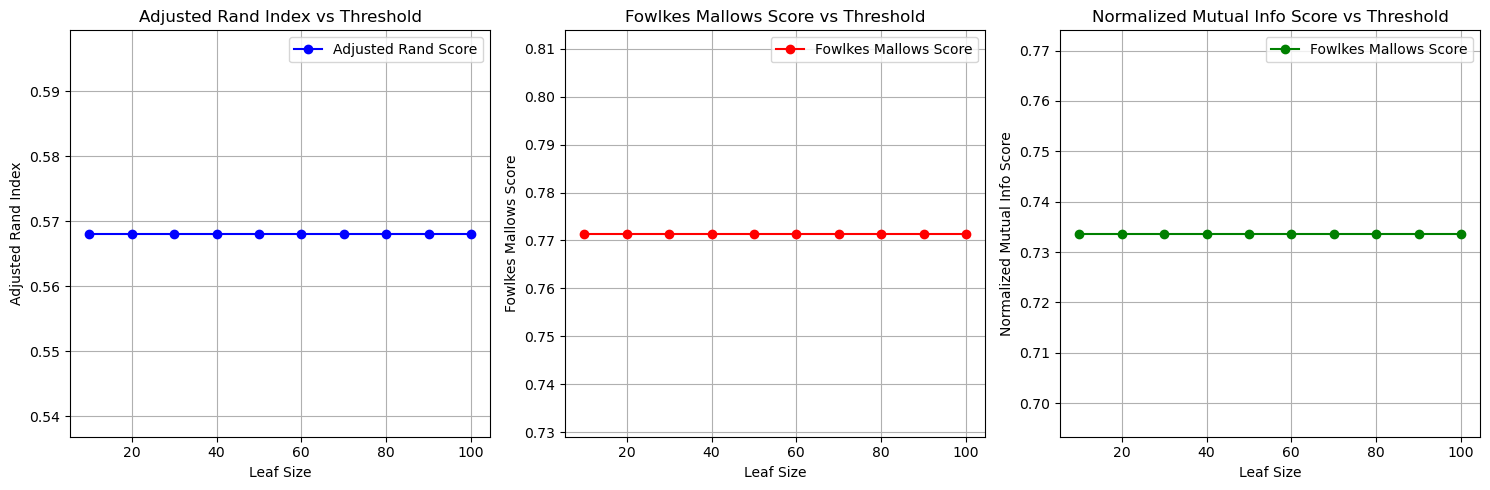

In [43]:
leaf_size = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ari = []
fowlkes_mallows = []
nmi = []



for i in leaf_size:
    hdbscan_model = hdbscan(leaf_size=i)
    hdbscan_model.fit(iris_no_target) 
    hdbscan_labels = hdbscan_model.labels_
    k_clusters = len(np.unique(hdbscan_labels))


    ari_score = adjusted_rand_score(iris['species'], hdbscan_labels)
    fm_score = fowlkes_mallows_score(iris['species'], hdbscan_labels)
    nmi_score = normalized_mutual_info_score(iris['species'], hdbscan_labels)
    print(f'Min Cluster size {i} number of clusters: {k_clusters}')

    
    ari.append(ari_score)
    fowlkes_mallows.append(fm_score)
    nmi.append(nmi_score)


# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot Adjusted Rand Score
ax[0].plot(leaf_size, ari, marker='o', linestyle='-', color='b', label="Adjusted Rand Score")
ax[0].set_title('Adjusted Rand Index vs Threshold')
ax[0].set_xlabel('Leaf Size')
ax[0].set_ylabel('Adjusted Rand Index')
ax[0].grid(True)
ax[0].legend()

# Plot Fowlkes Mallows Score
ax[1].plot(leaf_size, fowlkes_mallows, marker='o', linestyle='-', color='r', label="Fowlkes Mallows Score")
ax[1].set_title('Fowlkes Mallows Score vs Threshold')
ax[1].set_xlabel('Leaf Size')
ax[1].set_ylabel('Fowlkes Mallows Score')
ax[1].grid(True)
ax[1].legend()

# Plot Normalized Mutual Info Score
ax[2].plot(leaf_size, nmi, marker='o', linestyle='-', color='g', label="Fowlkes Mallows Score")
ax[2].set_title('Normalized Mutual Info Score vs Threshold')
ax[2].set_xlabel('Leaf Size')
ax[2].set_ylabel('Normalized Mutual Info Score')
ax[2].grid(True)
ax[2].legend()


# Show the plots
plt.tight_layout()
plt.show()


In [44]:
best_model = hdbscan(min_cluster_size=10)
best_model.fit(iris)
best_labels = best_model.labels_
iris['Cluster'] = best_labels

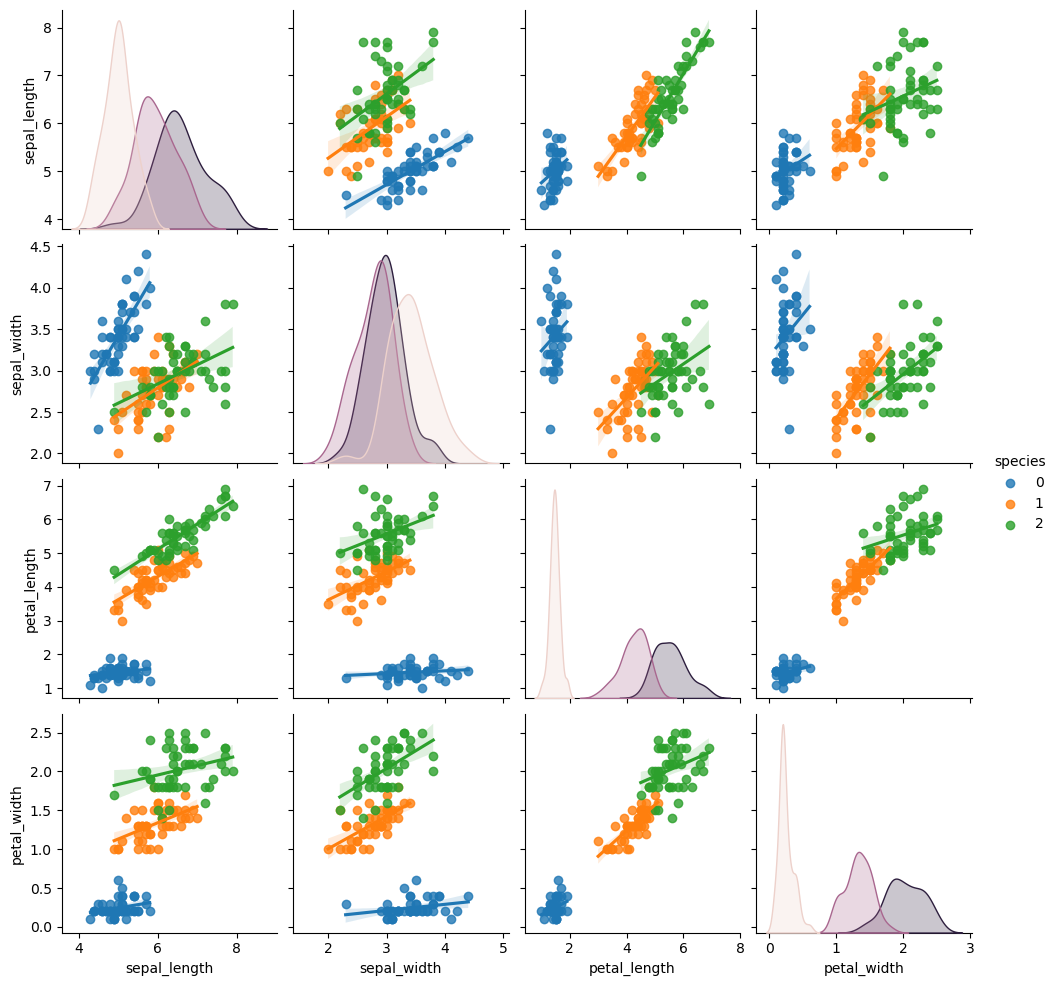

In [45]:
sns.pairplot(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']], hue='species', kind='reg')
plt.show()

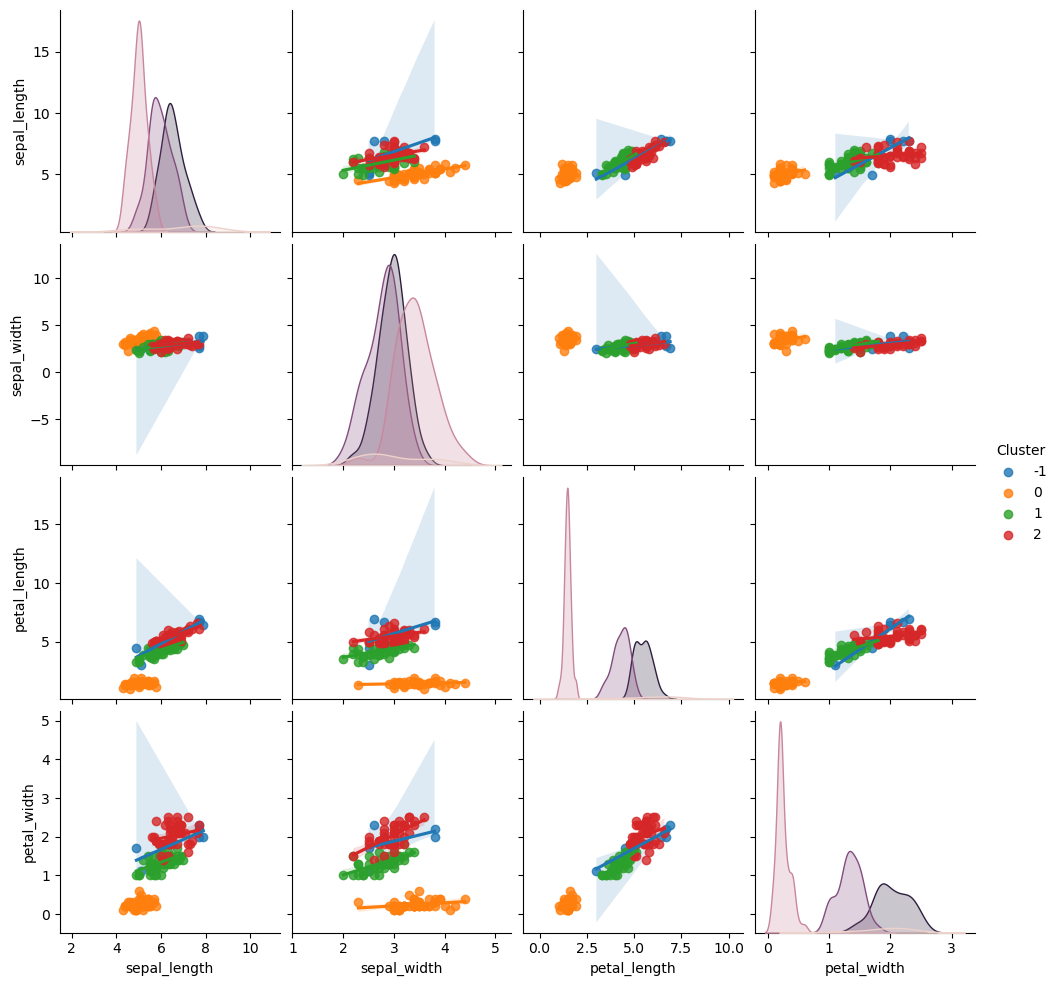

In [46]:
sns.pairplot(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'Cluster']], hue='Cluster', kind='reg')
plt.show()